# ARIMA 
### This code takes you through the steps taken to evaluate ARIMA for load forecasting
- Get log load and perform differencing on time series to stationarize data
- Get ACF and PACF of the time series
- Evaluate in-sample forecast using 364 train days and 1 test day (10 different times) for different p,d,q values
- Evaluate out-of-sample forecast " " " " " (10 different times) for ARIMA(3,1,2) and ARIMA(16,1,2)
- Helper functions for loading and organizing data and calculating errors


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.linear_model
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
get_ipython().magic('matplotlib inline')
from matplotlib.pylab import rcParams

E_NAMES = ['Electricity:Facility [kW](Hourly)','Electricity:HVAC [kW](Hourly)','General:InteriorLights:Electricity [kW](Hourly)','General:ExteriorLights:Electricity [kW](Hourly)','Appl:InteriorEquipment:Electricity [kW](Hourly)','Misc:InteriorEquipment:Electricity [kW](Hourly) ']
NEW_E_NAMES = ['Facility','HVAC','Lighting','Exterior','Appliances','Misc']

### Load in the data, get the logs of the time series, and difference the time series
- Differencing means calculating the difference between every value at time t and t - 1

In [4]:
electricity = setup('USA_CA_Mountain.View-Moffett.Field.NAS.745090_TMY3_HIGH.csv')
electricity.LogLoad = np.log(electricity.Facility)
shifted_log_load = electricity.LogLoad.shift()
shifted_log_load[0] = electricity.LogLoad.values[len(electricity.LogLoad.values) - 1]
electricity.LogLoadDiff = electricity.LogLoad - shifted_log_load
diffs = electricity.LogLoadDiff.values

### Get the ACF and PACF, then plot them

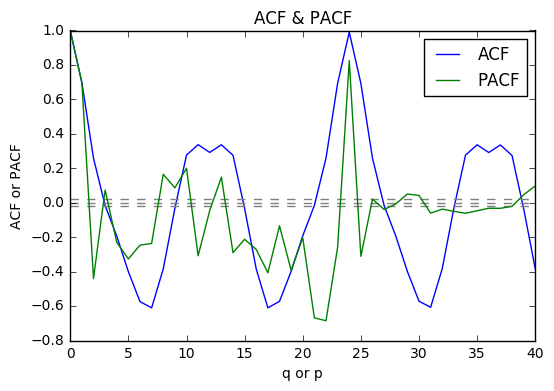

In [5]:
ACF = acf(diffs)
PACF = pacf(diffs)

plt.plot(ACF, label = 'ACF')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diffs)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diffs)),linestyle='--',color='gray')
plt.title('ACF & PACF')

plt.plot(PACF, label = 'PACF')
plt.xlabel('q or p')
plt.ylabel('ACF or PACF')
plt.legend(loc = 'best')

### Observe what index at which the ACF and PACF first cross 0

In [6]:
ACF

array([ 1.        ,  0.6966349 ,  0.25880456, -0.01644699, -0.19366949,
       -0.40044003, -0.57426307, -0.61035086, -0.38460614, -0.03250788,
        0.27643634,  0.33702505,  0.29217533,  0.3364768 ,  0.27542943,
       -0.03354263, -0.38547286, -0.61042054, -0.57249411, -0.3984181 ,
       -0.19237064, -0.01547386,  0.25889816,  0.69337899,  0.99069808,
        0.69264603,  0.25789718, -0.01630088, -0.19286512, -0.39870165,
       -0.57168623, -0.6073475 , -0.38247439, -0.03161903,  0.27613684,
        0.33622754,  0.29163526,  0.33555854,  0.27452559, -0.03302193,
       -0.38344446])

q crosses below 0 both at 3 and at 16

In [7]:
PACF

array([ 1.        ,  0.69671443, -0.44024907,  0.07356966, -0.2299972 ,
       -0.32643969, -0.2462658 , -0.23671082,  0.16526902,  0.0865006 ,
        0.1998409 , -0.30784788, -0.04525267,  0.14858625, -0.28980949,
       -0.21212311, -0.27144003, -0.40689398, -0.13363303, -0.39239269,
       -0.20364612, -0.66844632, -0.68533195, -0.25811215,  0.82490156,
       -0.31115673,  0.0212872 , -0.03935213, -0.00719749,  0.05031132,
        0.04241702, -0.06058381, -0.03723783, -0.04991984, -0.06131937,
       -0.04668421, -0.03210053, -0.0325011 , -0.02092052,  0.04597364,
        0.09742564])

p crosses zero at 2

### In-sample forecast

In [21]:
num_test_days = 10
test_days = np.random.randint(low = 0, high = 363, size = num_test_days) * 24
len_test_period = 24

RMSE = []
PCT = []
for td in test_days:
    adjusted_electricity = electricity[td:len(electricity)].append(electricity[0:td])
    print('Start time: %s' % adjusted_electricity.DateTime.values[0])
    adjusted_electricity.LogLoad = np.log(adjusted_electricity.Facility)
    shifted_log_load = adjusted_electricity.LogLoad.shift()
    shifted_log_load[0] = adjusted_electricity.LogLoad.values[len(adjusted_electricity.LogLoad.values) - 1]
    adjusted_electricity.LogLoadDiff = adjusted_electricity.LogLoad - shifted_log_load
    
    train_size = len(electricity) - len_test_period
    train, test = adjusted_electricity.LogLoad.values[0:train_size], adjusted_electricity.LogLoad.values[train_size:len(electricity)]
    history = [x for x in train]
    pred = []
    for t in range(len(test)):
        print(t)
        # Retrain each model according to the most-recently seen value
        model = ARIMA(history, order = (16, 1, 2))
        model_fit = model.fit(disp = -1)
        output = model_fit.forecast(disp = -1)
        fc = output[0][0]
        pred.append(fc)
        obs = test[t]
        history.append(obs)
        
    
    rmse = root_mean_squared_error(np.exp(pred), np.exp(test))
    pct = percent_error(pred, test)
    RMSE.append(rmse)
    PCT.append(pct)
    print('RMSE: %f, Percent: %f%%' % (rmse, pct*100))
  

Start time:  05/10  01:00:00
0


KeyboardInterrupt: 

### Print the average test errors

In [12]:
print('Average MSE: %f, Average Percent Error: %f%%' % (np.average(RMSE), np.average(PCT)*100))
print('STD on MSE: %f, STD on Percent Error: %f%%' % (np.std(RMSE), np.std(PCT)*100))

Average MSE: 0.059241, Average Percent Error: 4.307517%
STD on MSE: 0.010432, STD on Percent Error: 0.619889%


### Plot an example of an in-sample ARIMA forecast

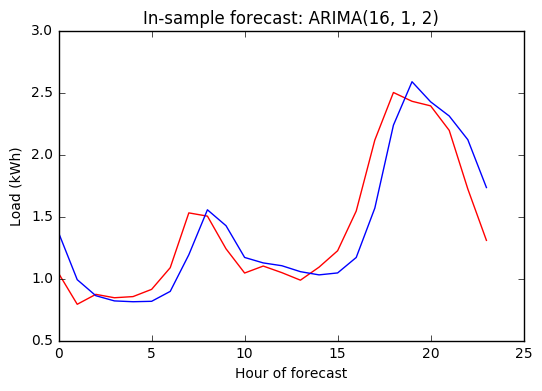

In [16]:
plt.plot(np.arange(len(pred)), np.exp(pred), color = 'red')
plt.plot(np.arange(24), np.exp(history[-1-24:-1]))
plt.title('In-sample forecast: ARIMA(16, 1, 2)')
plt.xlabel('Hour of forecast')
plt.ylabel('Load (kWh)')

### Out-of-sample forecast for p = 16 or 3 and q = 2

/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


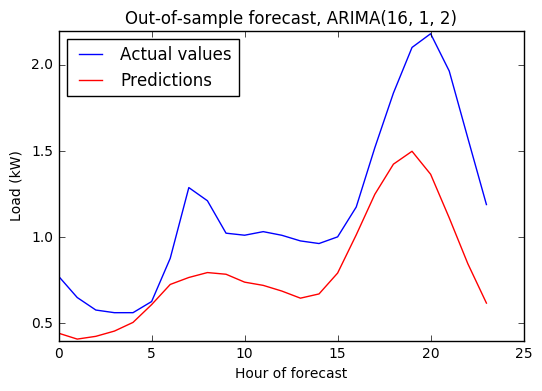

0.456774952
0.415054745284


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


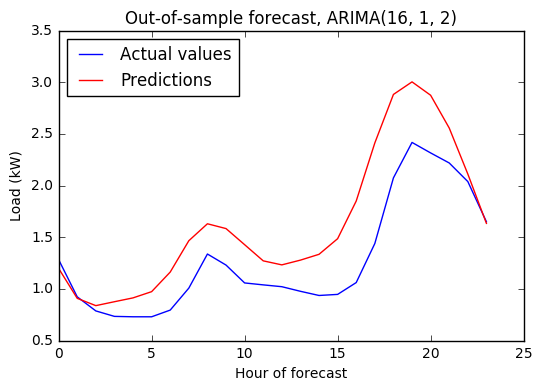

0.273951516749
0.430706646045


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


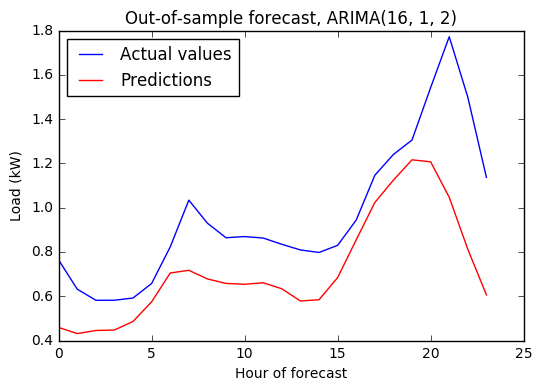

0.292138638389
0.295174316864


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


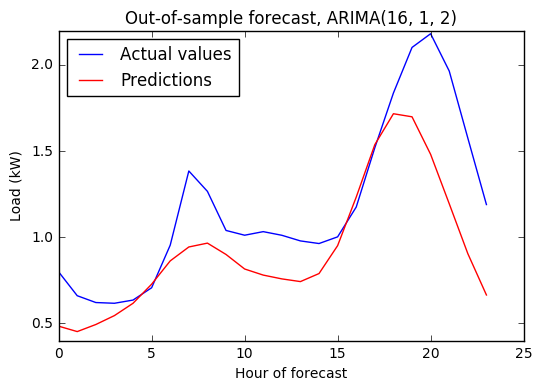

0.325966805999
0.336865648017


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


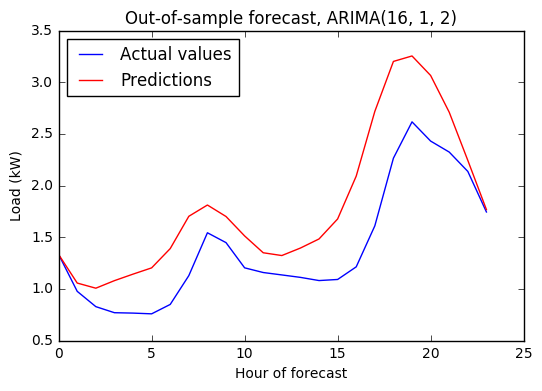

0.307237418896
0.492861981357


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


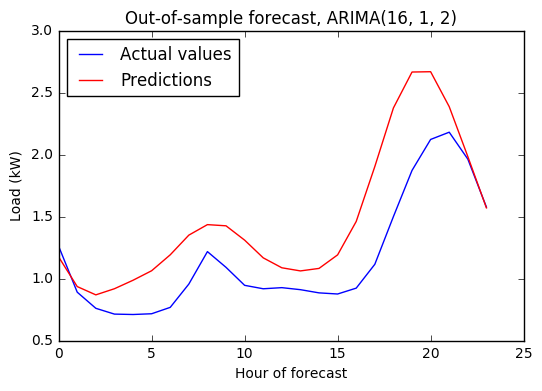

0.254143513419
0.397164376264


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


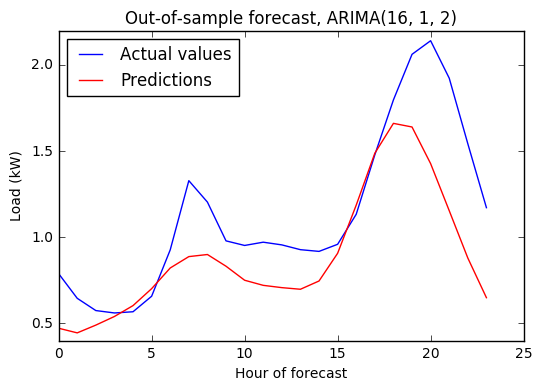

0.32547602206
0.337632166539


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


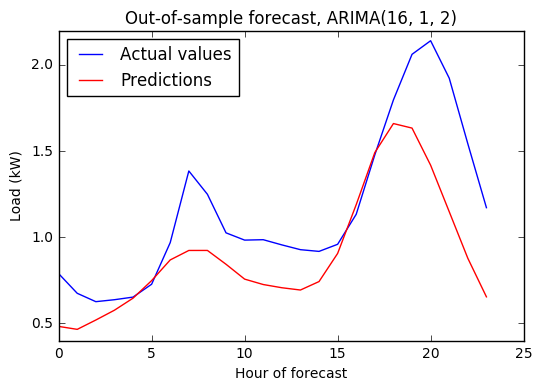

0.334128402433
0.343065535634


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


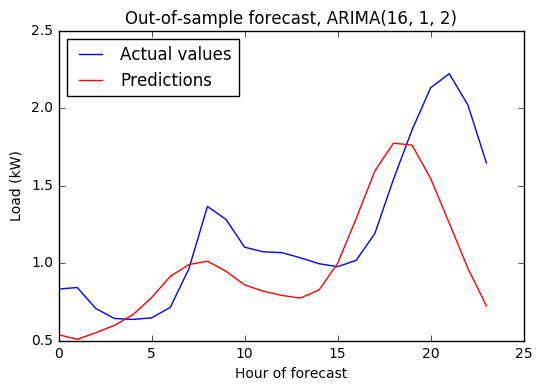

0.425066274577
0.425681805502


/Users/jappleby/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


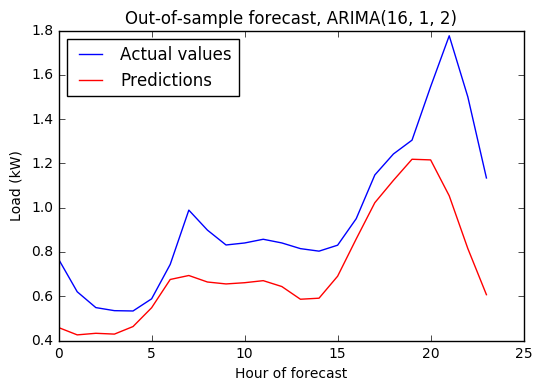

0.27643386603
0.287898142343


In [19]:
test_days = 364
p = 16
q = 2
test_days = np.random.randint(364, size = 10) * 24 # Index of starting point

RMSE = []
PCT = []
for td in test_days:
    adjusted_electricity = electricity[td:len(electricity)].append(electricity[0:td])
    train_size = 363 # Days to train
    train_size = train_size * 24 # Hours to train
    train,test = adjusted_electricity[0:train_size], adjusted_electricity[(train_size-1):len(electricity)]
    diff_history = [x for x in train.LogLoadDiff.values]
    history = [x for x in train.LogLoad.values]
    model = ARIMA(history, order = (p, 1, q))
    model_fit = model.fit(disp = -1)
    
    num_hours = 24
    log_diff_forecast = model_fit.forecast(steps = 24)[0]
    real = test.Facility.values[0:24]
    # Now we need to take these log-difference forecasts and return them to actual load values
    log_forecast = []
    for fc in log_diff_forecast:
        log_forecast.append(fc + history[-1])
    forecast = np.exp(log_forecast)
    
    plt.plot(np.arange(24), real, label = 'Actual values')
    plt.plot(np.arange(24), forecast, label = 'Predictions', color = 'red')
    plt.legend(loc = 'best')
    plt.title('Out-of-sample forecast, ARIMA(16, 1, 2)')
    plt.xlabel('Hour of forecast')
    plt.ylabel('Load (kW)')
    plt.show()
    
    PCT.append(percent_error(real, forecast))
    RMSE.append(root_mean_squared_error(real, forecast))

In [20]:
print('Average MSE: %f, Average Percent Error: %f%%' % (np.average(RMSE), np.average(PCT)*100))
print('STD on MSE: %f, STD on Percent Error: %f%%' % (np.std(RMSE), np.std(PCT)*100))

Average MSE: 0.376211, Average Percent Error: 32.713174%
STD on MSE: 0.062828, STD on Percent Error: 6.228770%


#### Helper functions

In [3]:
# setup loads 'filename' and renames it's columns for easy referencing.
def setup(filename):
    raw = pd.read_csv(filename)
    electricity = pd.DataFrame(columns = ['DateTime'] + NEW_E_NAMES + ['LogLoad','LogLoadDiff'])
    electricity[['Facility','HVAC','Lighting','Exterior','Appliances','Misc']] = raw[E_NAMES]
    #electricity.Month  = raw['Date/Time'].str[0:3].astype(int)
    #electricity.Day    = raw['Date/Time'].str[4:6].astype(int)
    #electricity.Hour   = raw['Date/Time'].str[8:10].astype(int)
    #electricity.Minute = raw['Date/Time'].str[11:13].astype(int)
    electricity.DateTime = raw['Date/Time']
    return electricity

def root_mean_squared_error(p, t):
    print(np.sqrt(np.average(np.square(p - t))))
    return np.sqrt(np.average(np.square(p - t)))

def percent_error(p, t):
    print(np.average(abs(np.exp(p) - np.exp(t)) / np.exp(t)))
    return np.average(abs(np.exp(p) - np.exp(t)) / np.exp(t))